In [266]:
import pandas as pd
import seaborn as sns
from datetime import datetime, date
import calendar
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from utils import oneHot, batch
import random
from __future__ import print_function
import tensorflow as tf
from tensorflow import reset_default_graph
import IPython.display as display
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline  

In [267]:
df = pd.read_csv('cleaned_sales+weather_data.csv')
df = df.drop('Unnamed: 0' , 1)
df['date'] = df['date'].map( lambda x: datetime.strptime( x, '%Y-%m-%d'))
df['weekofyear'] = df['date'].dt.weekofyear
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['dayofyear'] = df['date'].dt.dayofyear
df['station'] = df['station'].map( int )
df['year'] = df['date'].dt.year
# filter
df = df[df['oms'] > 0 ]
df[:3]

,EAN,Produkttekst,avance,chain_store,date,oms,postal_no,store_name,store_no,volume,station,temp,wind,sun,precipitations,weekofyear,month,weekday,dayofyear,year
0,5741000116975,Royal B X-mas 6x33ds,1,DagliBrugsen,2015-01-01,31.00,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015
1,5741000131084,Royal Export 6x33 ds,-13,DagliBrugsen,2015-01-01,100.00,2300,COOP DAGLIBR BRYDES ALLE,1043,4,618800,5.5,6.1,0,1.9,1,1,3,1,2015
2,5741000140284,ROYAL PLATINUM 6-PAK,8,DagliBrugsen,2015-01-01,39.95,2300,COOP DAGLIBR BRYDES ALLE,1043,1,618800,5.5,6.1,0,1.9,1,1,3,1,2015


In [268]:
features = ['oms','date','temp','sun','wind','precipitations', 'dayofyear','year','month','weekday', 'station']
q = df[features]
data = q#[ (q['month'] > 3) & (q['month'] < 10 ) ] #& (q['weekday'] == 4)]
# aggregate emp	wind	sun	precipitations
agg = data.groupby(['date', 'station' ])
aggregated_data = pd.DataFrame( { 'month' :  agg['month'].first() , 'weekday' :  agg['weekday'].first(), 'oms' : agg['oms'].sum(), 'temp':agg['temp'].first() , 'sun' : agg['sun'].first(), 'wind' : agg['wind'].first(),  'precipitations' : agg['precipitations'].first() , 'year' : agg['year'].first(), 'dayofyear' : agg['dayofyear'].first()  } )
aggregated_data.reset_index(level=0, inplace=True)
aggregated_data.reset_index(level=0, inplace=True)

df = aggregated_data
df[:3]

,station,date,dayofyear,month,oms,precipitations,sun,temp,weekday,wind,year
0,603100,2015-01-01,1,1,22080.76,4.5,0,6.7,3,8.7,2015
1,607200,2015-01-01,1,1,36691.96,1.0,0,6.8,3,5.7,2015
2,612600,2015-01-01,1,1,28939.93,0.3,0,5.4,3,8.6,2015


## temperature, precipitations and sun effects on beer sales

In [292]:
A = np.percentile(df['oms'], 10)
B = np.percentile(df['oms'], 90)
print(A)
print(B)
def revenueLabel(x):
    if x < A:
        return 'bad'
    elif x < B:
        return 'average'
    else:
        return 'good'
    
def revenueLabel2(x):
    res = 'neg'
    for i in range(10):
        if x > np.percentile(df['oms'], 10*i):
            res = "Q"+str(i) 
    return res
    
    
df['revenue category'] = df['oms'].map(revenueLabel)

69636.564
214832.745


#### precipitations

Precipitations level seems to have a little effect on sales

[]

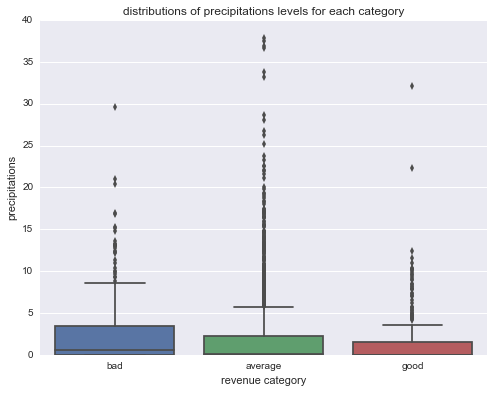

In [293]:
plt.figure(figsize=(8,6))
key='precipitations'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of precipitations levels for each category')
plt.plot()

#### wind

Wind seems to have a little effect. Wind is also correlated to the sun exposition time.

[]

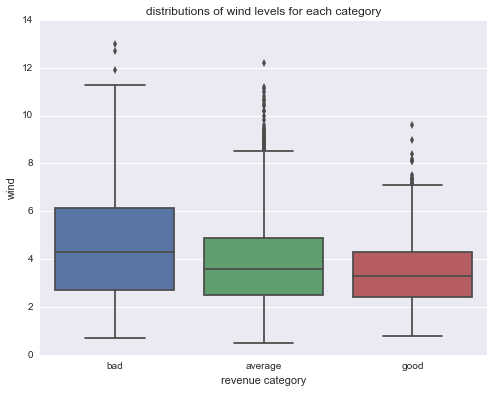

In [294]:
plt.figure(figsize=(8,6))
key='wind'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of wind levels for each category')
plt.plot()

#### Sun and Temperature

[]

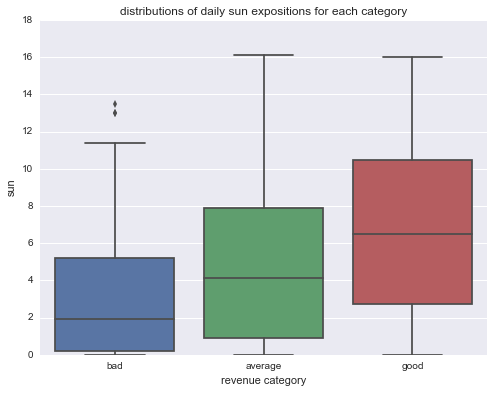

In [295]:
plt.figure(figsize=(8,6))
key='sun'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of daily sun expositions for each category')
plt.plot()

[]

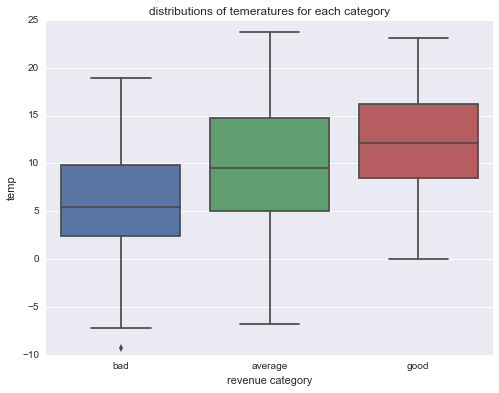

In [296]:
plt.figure(figsize=(8,6))
key='temp'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of temeratures for each category')
plt.plot()

Those two elements seem to have a big impact on the sales. The sun seems to be the most important parameter.

[]

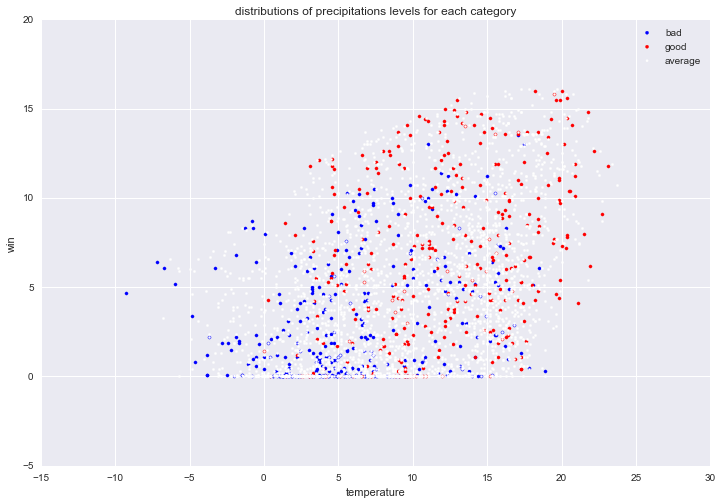

In [306]:
plt.figure(figsize=(12,8))
cs =  list(set(df['revenue category']))
dd = df[ df['revenue category'] == cs[0] ]
plt.scatter(dd['temp'] , dd['sun'] , color='blue', s=10, label=cs[0])
dd = df[ df['revenue category'] == cs[1] ]
plt.scatter(dd['temp'] , dd['sun'] , color='red', s=10, label=cs[1])
dd = df[ df['revenue category'] == cs[2] ]
plt.scatter(dd['temp'] , dd['sun'] , color='white', s=5, label=cs[2])
plt.plot()
plt.legend()
plt.xlabel('temperature')
plt.ylabel('win')
plt.title('distributions of precipitations levels for each category')
plt.plot()

### sun exposure and revenues for each station and each year during summer (trying to see some patterns)

station: 607200
2016


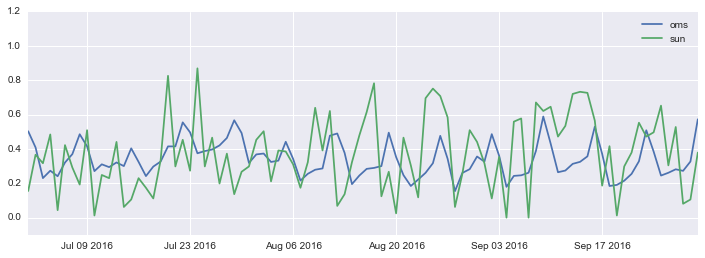

2015


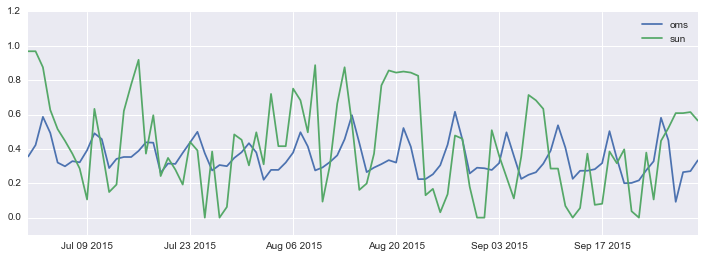

station: 612600
2016


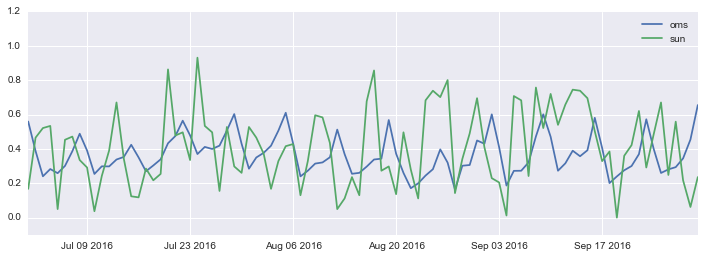

2015


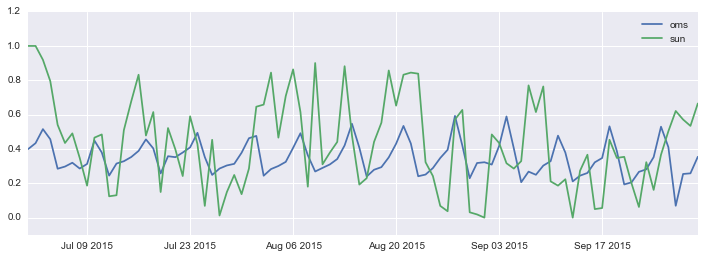

station: 617400
2016


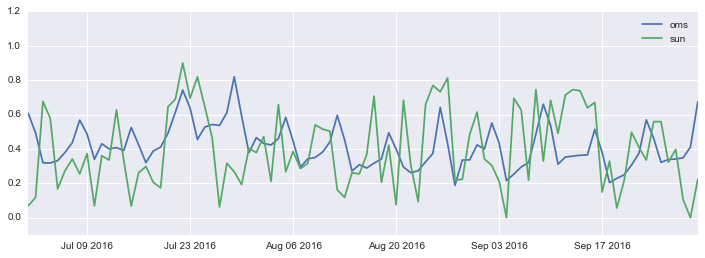

2015


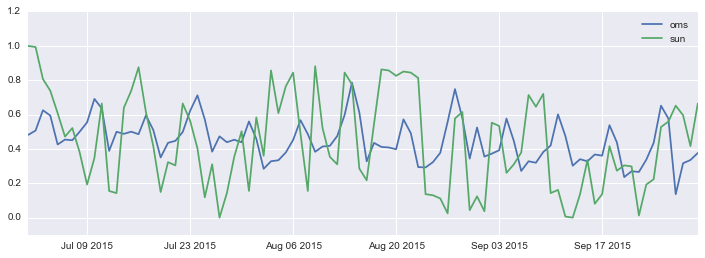

station: 603100
2016


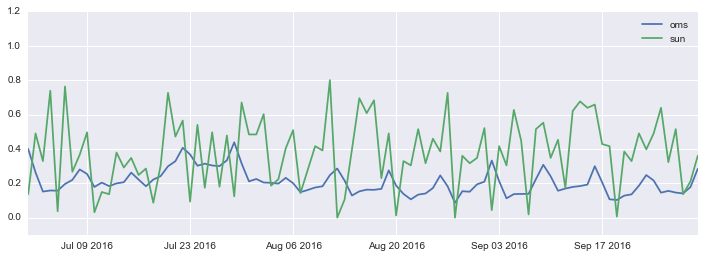

2015


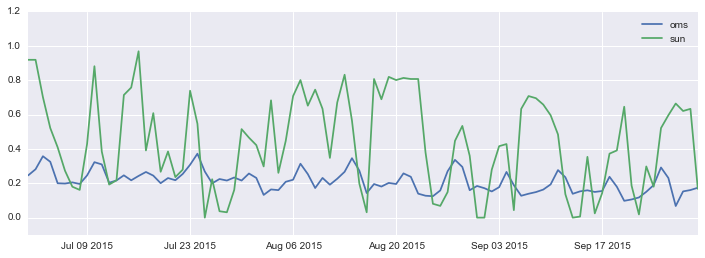

station: 618800
2016


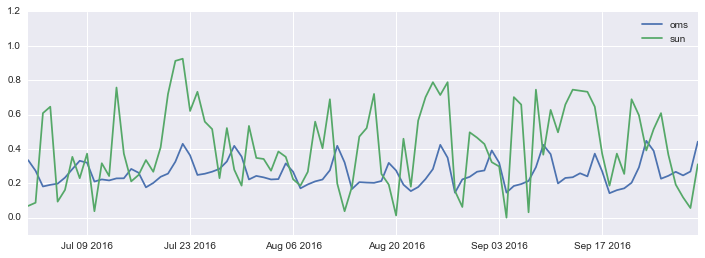

2015


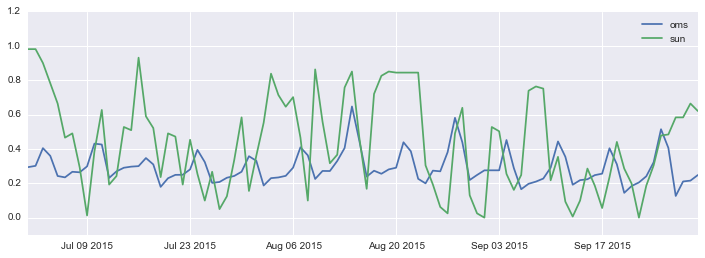

In [298]:
stations = set(df['station'])
for s in stations:
    print ("station: " + str(s))
    dd = df[ (df['station'] == s) & (df['month'] > 6) & (df['month'] < 10) ]
    for y in set(dd['year']):
        print (y)
        plt.figure(figsize=(12,4))
        ddd = dd[ dd['year'] == y]
        plt.plot_date(ddd['date'] , ddd['oms']/max(df['oms']), '-', label='oms')
        #plt.plot_date(ddd['date'] , ddd['temp']/max(df['temp']),'-',label='temp')
        plt.plot_date(ddd['date'] , ddd['sun']/max(df['sun']),'-',label='sun')
        plt.legend()
        plt.ylim([-0.1,1.2])
        plt.show()

## influence of the sun exposure during the previous days on sales

In [308]:
from datetime import datetime, timedelta

def averageExposureDays(data, day, station, N ,  direction ):
    direction = direction 
    ds = data[  data['station'] == station ]
    if direction != 0:
        date_N_days_ago = day + direction * timedelta(days=N)
        dmin = min(day,date_N_days_ago)
        dmax = max(day,date_N_days_ago)
    else:
        date_N_days_ago = day - timedelta(days=N)
        dmin = min(day,date_N_days_ago)
        date_N_days_ago = day +  timedelta(days=N)
        dmax = max(day,date_N_days_ago)
    dd = ds[ (ds['date'] != day) & (ds['date'] <= dmax) & (dmin <= ds['date'] ) ]
    if len(dd) == 0:
        return ds[ data['date'] == day ]['sun'].values[0]
    else:
        return np.sum(dd['sun'])
        
        
print (averageExposureDays(df, df['date'][100] , df['station'][100], 5, -1 ) )

print (averageExposureDays(df, df['date'][100] , df['station'][100], 5, 1 ) ) 

6.2
10.2


In [309]:
d_copy = df
for dirr in [-1,0,1]:
    print(dirr)
    N = 4
    values = []
    for i in range(len(df)):
        m = averageExposureDays(d_copy, d_copy['date'][i] , d_copy['station'][i] , N, dirr)
        values.append(m)
    d_copy['sun_exposure_for_'+str(N)+'days-dir:'+str(dirr)] = values

-1
0
1


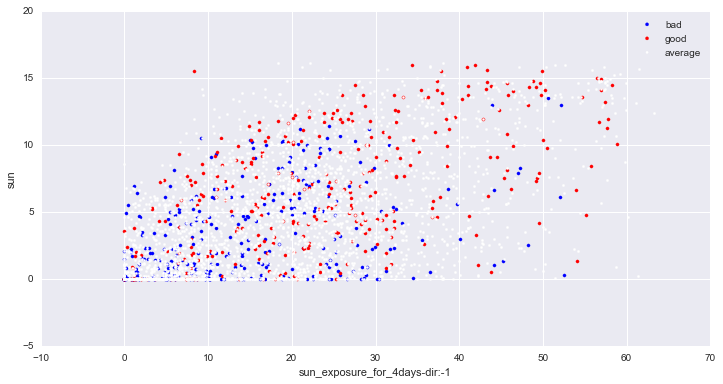

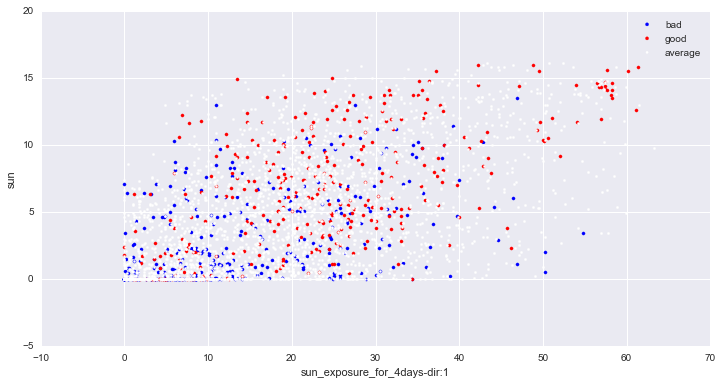

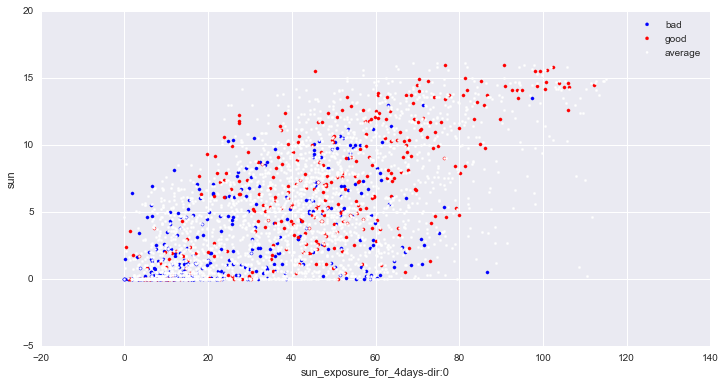

In [310]:
for key in ['sun_exposure_for_4days-dir:-1','sun_exposure_for_4days-dir:1','sun_exposure_for_4days-dir:0']:
    plt.figure(figsize=(12,6))
    cs =  list(set(df['revenue category']))
    dd = df[ df['revenue category'] == cs[0] ]
    plt.scatter(dd[key] , dd['sun'] , color='blue', s=10, label=cs[0])
    dd = df[ df['revenue category'] == cs[1] ]
    plt.scatter(dd[key] , dd['sun'] , color='red', s=10, label=cs[1])
    dd = df[ df['revenue category'] == cs[2] ]
    plt.scatter(dd[key] , dd['sun'] , color='white', s=5, label=cs[2])
    plt.plot()
    plt.legend()
    plt.xlabel(key)
    plt.ylabel('sun')
    plt.plot()

In [302]:
d_copy[:3]

,station,date,dayofyear,month,oms,precipitations,sun,temp,weekday,wind,year,revenue category,sun_exposure_for_4days-dir:-1,sun_exposure_for_4days-dir:1
0,603100,2015-01-01,1,1,22080.76,4.5,0,6.7,3,8.7,2015,bad,0,11.5
1,607200,2015-01-01,1,1,36691.96,1.0,0,6.8,3,5.7,2015,bad,0,10.1
2,612600,2015-01-01,1,1,28939.93,0.3,0,5.4,3,8.6,2015,bad,0,10.2


[]

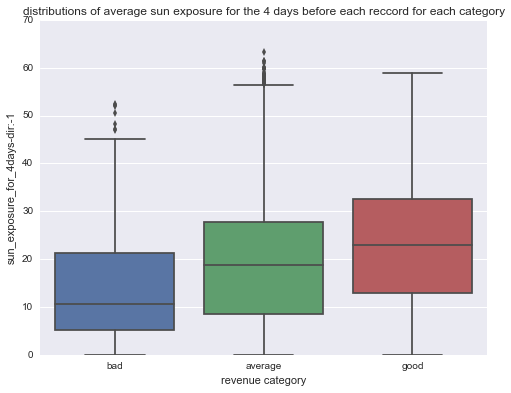

In [303]:
plt.figure(figsize=(8,6))
key='sun_exposure_for_4days-dir:-1'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of average sun exposure for the 4 days before each reccord for each category')
plt.plot()

[]

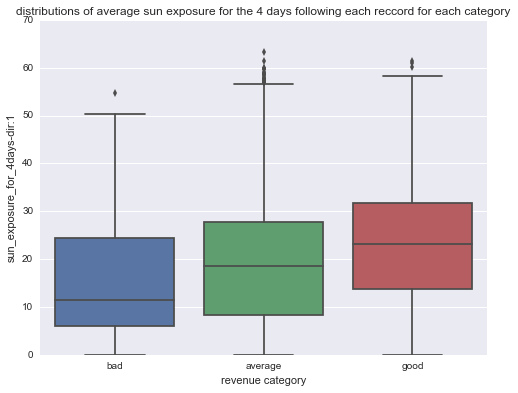

In [311]:
plt.figure(figsize=(8,6))
key='sun_exposure_for_4days-dir:1'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of average sun exposure for the 4 days following each reccord for each category')
plt.plot()

[]

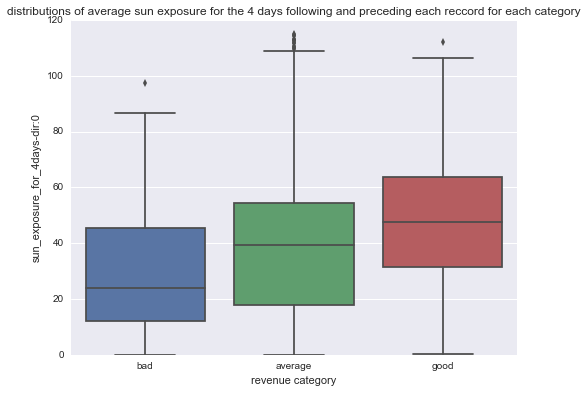

In [312]:
plt.figure(figsize=(8,6))
key='sun_exposure_for_4days-dir:0'
sns.boxplot(df['revenue category'] , df[key] )
plt.plot()
plt.legend()
plt.xlabel('revenue category')
plt.ylabel(key)
plt.title('distributions of average sun exposure for the 4 days following and preceding each reccord for each category')
plt.plot()

These two diagrams show that people are more likely to buy beer when it's sunny before and after the day they buy beer. We can assume therefore that people are buying beer during sunny period of times (sunny during multiple days). In other words, in summer..